In [1]:
import matplotlib.pyplot as plt
import cv2
import onnxruntime
import h5py
import more_itertools
import tqdm
import numpy as np
import onnx

In [2]:
# 1) download data from https://github.com/deepinsight/insightface/tree/master/recognition/_datasets_
# 2) unpack then to data
# 3) list the contents to a txt file
P = 1
files = np.asarray(list(map(str.strip, open("../lists/glint360.txt").readlines())))
subset = np.random.RandomState(2463426724).random(len(files)) < P
subset_files = files[subset]
root = "../data/"

In [3]:
len(files)

17091657

In [4]:
files[0]

'./glint_orig/id_143405/143405_6374412.jpg'

In [5]:
example = cv2.imread(root+files[10000])

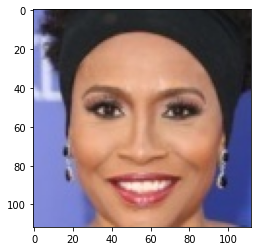

In [6]:
plt.imshow(example[...,::-1])

In [7]:
model_file = "webface_r50_pfc.onnx" # https://github.com/deepinsight/insightface/tree/master/model_zoo
#model_file = "ms1m_megaface_r50.onnx" # https://github.com/deepinsight/insightface/tree/master/model_zoo

In [8]:
model = onnx.load_model(model_file)

In [9]:
find_sub = find_mul = False
for nid, node in enumerate(model.graph.node[:8]):
    if node.name.startswith('Sub') or node.name.startswith('_minus'):
        find_sub = True
    if node.name.startswith('Mul') or node.name.startswith('_mul'):
        find_mul = True
if find_sub and find_mul:
    #mxnet arcface model
    input_mean = 0.0
    input_std = 1.0
else:
    input_mean = 127.5
    input_std = 127.5
input_size = (112, 112)

In [10]:
def prepare_batch(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    blob = cv2.dnn.blobFromImages(imgs, 1.0 / input_std, input_size,
                                  (input_mean, input_mean, input_mean), swapRB=True)
    return blob

In [11]:
prepare_batch(example).shape

(1, 3, 112, 112)

In [12]:
model.graph.node[-4]#.output[0]

input: "679"
input: "bn2.weight"
input: "bn2.bias"
input: "bn2.running_mean"
input: "bn2.running_var"
output: "680"
name: "BatchNormalization_126"
op_type: "BatchNormalization"
attribute {
  name: "epsilon"
  f: 9.999999747378752e-06
  type: FLOAT
}
attribute {
  name: "momentum"
  f: 0.8999999761581421
  type: FLOAT
}

In [13]:
model = onnx.load_model(model_file)
intermediate_tensor_name = model.graph.node[-4].output[0]
intermediate_layer_value_info = onnx.helper.ValueInfoProto()
intermediate_layer_value_info.name = intermediate_tensor_name
model.graph.output.extend([intermediate_layer_value_info])
onnx.save(model, "interim+"+model_file)

In [14]:
session = onnxruntime.InferenceSession("interim+"+model_file, None)

In [15]:
input_cfg = session.get_inputs()[0]
output_cfg = [t.name for t in session.get_outputs()]
input_name = input_cfg.name

In [16]:
output_cfg

['683', '680']

In [17]:
net_out = session.run(output_cfg, {input_name: prepare_batch(example)})

In [18]:
net_out[0].shape

(1, 512)

In [ ]:
with tqdm.tqdm(subset_files) as _files, h5py.File(model_file + f".{P}-embeddings.h5", "w") as f:
    prefacen = f.create_dataset("prefacen", (0, 512), maxshape=(None, 512), chunks=(512, 512))
    facen = f.create_dataset("facen", (0, 512), maxshape=(None, 512), chunks=(512, 512))
    for images in more_itertools.chunked(
            map(cv2.imread, map(root.__add__, _files))
        , 512):
        batch = prepare_batch(images)
        facen_i, prefacen_i = session.run(output_cfg, {input_name: batch})
        prefacen.resize((prefacen.shape[0]+prefacen_i.shape[0], prefacen.shape[1]))
        facen.resize((facen.shape[0]+facen_i.shape[0], facen.shape[1]))
        prefacen[-prefacen_i.shape[0]:] = prefacen_i[..., prefacen_i.shape[-1] // 2, prefacen_i.shape[-1] // 2]
        facen[-facen_i.shape[0]:] = facen_i

  2%|▏         | 291954/17091657 [08:08<9:15:25, 504.11it/s] 